## To begin, let's connect to the Azure SQL Database and query some data.

In [1]:
import pyodbc
import pandas
import json

with open('login_creds.json') as f:
    login = json.load(f)

conn_str = (
    r'Driver=SQL Server;' +
    r'Server={};'.format(login['Server']) +
    r'Database={};'.format(login['Database']) + 
    'UID={};'.format(login['Username']) +
    'PWD={};'.format(login['Password'])
    )
cnxn = pyodbc.connect(conn_str)

In [2]:
def query_db(query, connection):

    cursor = connection.cursor()
    cursor.execute(query)
    rows = []
    for row in cursor.fetchall():
        rows.append(row)
    columns = [column[0] for column in cursor.description]

    df = pandas.DataFrame.from_records(rows, columns = columns)
    
    return df

In [3]:
sale = query_db("SELECT f.*, d.FullDate FROM FactSales f JOIN DimDate d on d.datekey = f.datekey", cnxn)
customer = query_db("SELECT * FROM DimCustomer", cnxn)

### Now, the data from these tables is in memory, stored in a dataframe. 

We can work with this table similarly to how you might work with a table in SQL, but with python and a package called pandas!


...

## On to the business problem!
### Can we use data science and build a model to help us determine how much business a future customer will contribute over time?

First, let's work on manipulating our data.

A common, simple technique to summarize customer purchasing behavior for further analysis (like segmentation) is referred to as RFM- recency, frequency, and magnitude of a customer's purchases. 

* **Recency:** days since last invoice, compared the overall most recent invoice across all customers
* **Frequency:** count of unique invoices
* **Magnitude:** total sum of invoice dollars

In [5]:
total_sales_by_customer = sale.groupby('CustomerKey').TotalSaleAmt.sum().astype(float)
total_sales_by_customer.describe()

count       663.000000
mean     267925.002112
std       57161.915495
min        7240.200000
25%      242718.475000
50%      277334.000000
75%      304468.375000
max      384393.350000
Name: TotalSaleAmt, dtype: float64

Here, we'll calculate the column we will train a model to predict. 

This is a simple transformation of the customer's total spend. If it's over $275,000, this value will be High Spender, and if below, Low Spender.

In [6]:
total_sales_by_customer = total_sales_by_customer.reset_index()
total_sales_by_customer['LifetimeValue'] = 'Low Spender'
total_sales_by_customer.loc[total_sales_by_customer.TotalSaleAmt > 275000, 'LifetimeValue'] = 'High Spender'

We'll try to predict which customers will be high spenders and which will be low spenders over the course of their engagement with the business. 

What type of problem is this? Classification, regression, or unsupervised?

.

.

.

.

.

.

.

.

.

.

.

### Classification! 

We could also solve this as a regression problem if we wanted to predict the actual dollar amount the customer would bring us. But since we are just trying to "classify" our customers into high and low life-time spend, this is a classification problem.

.


So. Let's create a training dataset so that we can train a model to learn patterns in our customers that might indicate
if they end up becoming high spenders or low spenders. 

Once our model is trained, we can then use it to make predictions for future customers, where we don't know the "right"
answer yet- what their fate is with our company!

For our data, everything is historically captured. We know the "right" answer- if the customers end up as high spenders or
low spenders. So, we have to simulate some training data such that we don't yet "know the right answer".

You'll see what I mean.

In [9]:
from datetime import datetime

# Data type conversion
sale['FullDate'] = sale['FullDate'].astype(str).apply(lambda x: datetime.fromisoformat(x))
sale['UnitSalePrice'] = sale['UnitSalePrice'].astype(float)

sale_dataset = sale.copy()
sale_dataset = sale_dataset.groupby('CustomerKey').FullDate.min().rename('FirstSaleDate').reset_index()

sale_dataset['OneYearAfter'] = sale_dataset['FirstSaleDate'].apply(lambda x: x.replace(year = x.year + 1))

To create training data, let's act like we only have a year of data on our customers. 

We'll generate features only off of this one year of data. 

In real life, when we want to use our model moving forward, we'll be able to use it to predict high/low lifetime spend for customers that have been with us for one year. 

This is all the information we'll have, so we're pretending it's all we have here!

In [10]:
sale_features = sale.copy()
sale_features = sale_features.merge(sale_dataset, on = 'CustomerKey')
sale_features = sale_features[sale_features.FullDate < sale_features.OneYearAfter]

From this data, we have information on customer purchases during their first year of engagement with the company. 
We also have some information related to the customer from DimCustomer. 

What are some things we can think of that might be predictive of a customer becoming a high spender/low spender?
If you had to make a guess for each customer, what are some thing that you might want to know about them to help you
determine this? 

#### These pieces of information are called our "features". 
We'll eventually feed them to our model so that it can learn patterns
in the pieces of information and how they are associated with a liklihood of becoming a high spender or a low spender.

Some pieces of information that I would think of if I was trying to decide (that we also have available in our data):
- How many purchases have they made so far?
- How much money have they spent with us so far?
- Have they bought a lot of different products with us, or just a few?
- Do they tend to buy expensive products? 
- Do they tend to buy a lot of units of product?

- Do they have a credit limit?
- What type of customer are they? (Novelty Shop, Gift Store, etc.)





We have the data for all of these features, but they aren't in the exact right format to pass to a model. 

For example, in the data we can find our how many purchases a person has made, but currently, our table has a different
row for each purchase. We're really looking for all of our features at the customer grain - each row is one customer, 
with one value for each feature above. Customer Key: 1, PurchasesMade: 50, TotalSpend: $50,000, etc.

Let's do some ~ feature engineering ~ to create these features and add them to our dataset!

In [12]:
purchases_made = sale_features.groupby('CustomerKey').DateKey.nunique().rename('PurchasesMade').reset_index()
total_spend = sale_features.groupby('CustomerKey').TotalSaleAmt.sum().rename('TotalSpend').reset_index()
unique_products = sale_features.groupby('CustomerKey').ProductKey.nunique().rename('UniqueProductCount').reset_index()
avg_unit_price = sale_features.groupby('CustomerKey').UnitSalePrice.mean().rename('AvgUnitPrice').reset_index()
avg_units = sale_features.groupby('CustomerKey').UnitQuantitySold.mean().rename('AvgUnitsBought').reset_index()

customer_features = customer[['CustomerKey', 'CreditLimit', 'CustomerType']]

customer_features = customer_features.merge(purchases_made).merge(total_spend).merge(unique_products).merge(avg_unit_price).merge(avg_units)

Cool, so we have created some additional piece of information associated with our customers that may help a model 
identify patterns and make accurate predictions. Take a look!

In [13]:
customer_features

,CustomerKey,CreditLimit,CustomerType,PurchasesMade,TotalSpend,UniqueProductCount,AvgUnitPrice,AvgUnitsBought
0,1,None,Novelty Shop,36,92707.6000,97,44.238651,40.666667
1,2,None,Novelty Shop,27,50135.0000,78,29.394891,41.695652
2,3,None,Novelty Shop,36,101489.6500,102,34.383088,29.875000
3,4,None,Novelty Shop,33,94550.6500,94,49.356552,39.293103
4,5,None,Novelty Shop,27,67880.4000,81,50.424286,37.224490
...,...,...,...,...,...,...,...,...
658,659,1600.00,Computer Store,17,47216.2500,52,34.240357,48.178571
659,660,1900.00,Gift Store,13,54552.4000,46,77.557000,41.600000
660,661,1800.00,Supermarket,8,13208.1000,28,45.761667,34.266667
661,662,1100.00,Corporate,4,7240.2000,14,36.086667,36.866667


### But we aren't done yet! 

We still need to do some additional processing on these features for our model to get the most 
out of them. 

For numeric or "continuous" features, like spend and price above, many algorithms prefer these values to be "normalized" 
by subtracting their mean and dividing by their standard deviation. This puts all of the numeric values in the same scale.
We're going to be testing out a random forest classifier for our algorithm, which is okay with unnormalized values, so 
for our purposes we'll leave them as is. 

For features that are "categorical", like the string columns above, our model won't understand how to interpret these 
text values. Model, like computers, are smart, but very stupid, and can't read. They only understand numbers.

Let's take our credit limit column, for example. I would like to be able to tell our model that yes, this customer has
a credit limit, or no, this customer does not. 
Up above though, we have entries for "None" and for the dollar amount of the limit. I really want "Yes" and "No", or 
"True" and "False". 
Computers and models think of True and False as 1 and 0. Let's create this "binary/boolean" column of 1's and 0's
to pass to our model!

In [14]:
customer_features['HasCreditLimit'] = [0 if credit_limit == None else 1 for credit_limit in
                                               customer_features.CreditLimit.tolist()]
customer_features

,CustomerKey,CreditLimit,CustomerType,PurchasesMade,TotalSpend,UniqueProductCount,AvgUnitPrice,AvgUnitsBought,HasCreditLimit
0,1,None,Novelty Shop,36,92707.6000,97,44.238651,40.666667,0
1,2,None,Novelty Shop,27,50135.0000,78,29.394891,41.695652,0
2,3,None,Novelty Shop,36,101489.6500,102,34.383088,29.875000,0
3,4,None,Novelty Shop,33,94550.6500,94,49.356552,39.293103,0
4,5,None,Novelty Shop,27,67880.4000,81,50.424286,37.224490,0
...,...,...,...,...,...,...,...,...,...
658,659,1600.00,Computer Store,17,47216.2500,52,34.240357,48.178571,1
659,660,1900.00,Gift Store,13,54552.4000,46,77.557000,41.600000,1
660,661,1800.00,Supermarket,8,13208.1000,28,45.761667,34.266667,1
661,662,1100.00,Corporate,4,7240.2000,14,36.086667,36.866667,1


Similarly for our CustomerType column, our model won't understand Novelty Shop and Computer Store and Gift Store.
Our model will understand 1's and 0's indicating if the customer is of that type.
ex. If a customer is Type Supermarket, Supermarket is 1, Novelty Shop is 0, Gift Store is 0, Corporate is 0, ... etc.
So imagine instead of one column, each CustomerType value got its own column, and this column is populated with 1's and 0's.

This would be a pain to do manually, and is one of the most common tasks done in preprocessing for machine learning, so
fortunately there are tons of functions out there that will automatically do this for us.

In [15]:
customer_features = pandas.concat((customer_features, pandas.get_dummies(customer_features.CustomerType)), axis = 1)
customer_features

,CustomerKey,CreditLimit,CustomerType,PurchasesMade,TotalSpend,UniqueProductCount,AvgUnitPrice,AvgUnitsBought,HasCreditLimit,Computer Store,Corporate,Gift Store,Novelty Shop,Supermarket
0,1,None,Novelty Shop,36,92707.6000,97,44.238651,40.666667,0,0,0,0,1,0
1,2,None,Novelty Shop,27,50135.0000,78,29.394891,41.695652,0,0,0,0,1,0
2,3,None,Novelty Shop,36,101489.6500,102,34.383088,29.875000,0,0,0,0,1,0
3,4,None,Novelty Shop,33,94550.6500,94,49.356552,39.293103,0,0,0,0,1,0
4,5,None,Novelty Shop,27,67880.4000,81,50.424286,37.224490,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,659,1600.00,Computer Store,17,47216.2500,52,34.240357,48.178571,1,1,0,0,0,0
659,660,1900.00,Gift Store,13,54552.4000,46,77.557000,41.600000,1,0,0,1,0,0
660,661,1800.00,Supermarket,8,13208.1000,28,45.761667,34.266667,1,0,0,0,0,1
661,662,1100.00,Corporate,4,7240.2000,14,36.086667,36.866667,1,0,1,0,0,0


### Looking good! 

Now that we have our features, let's combine this dataframe with our prediction column
and get to modeling!

.
.
.

Which columns do you think we're going to pass to our model?

Which columns are predictive? 

What's the "answer" column?

In [16]:
classify_spend_dataset = customer_features.merge(total_sales_by_customer[['CustomerKey', 'LifetimeValue']])
print(classify_spend_dataset.columns)
classify_spend_dataset

Index(['CustomerKey', 'CreditLimit', 'CustomerType', 'PurchasesMade',
       'TotalSpend', 'UniqueProductCount', 'AvgUnitPrice', 'AvgUnitsBought',
       'HasCreditLimit', 'Computer Store', 'Corporate', 'Gift Store',
       'Novelty Shop', 'Supermarket', 'LifetimeValue'],
      dtype='object')


,CustomerKey,CreditLimit,CustomerType,PurchasesMade,TotalSpend,UniqueProductCount,AvgUnitPrice,AvgUnitsBought,HasCreditLimit,Computer Store,Corporate,Gift Store,Novelty Shop,Supermarket,LifetimeValue
0,1,None,Novelty Shop,36,92707.6000,97,44.238651,40.666667,0,0,0,0,1,0,High Spender
1,2,None,Novelty Shop,27,50135.0000,78,29.394891,41.695652,0,0,0,0,1,0,Low Spender
2,3,None,Novelty Shop,36,101489.6500,102,34.383088,29.875000,0,0,0,0,1,0,High Spender
3,4,None,Novelty Shop,33,94550.6500,94,49.356552,39.293103,0,0,0,0,1,0,High Spender
4,5,None,Novelty Shop,27,67880.4000,81,50.424286,37.224490,0,0,0,0,1,0,Low Spender
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,659,1600.00,Computer Store,17,47216.2500,52,34.240357,48.178571,1,1,0,0,0,0,Low Spender
659,660,1900.00,Gift Store,13,54552.4000,46,77.557000,41.600000,1,0,0,1,0,0,Low Spender
660,661,1800.00,Supermarket,8,13208.1000,28,45.761667,34.266667,1,0,0,0,0,1,Low Spender
661,662,1100.00,Corporate,4,7240.2000,14,36.086667,36.866667,1,0,1,0,0,0,Low Spender


In [17]:
features = classify_spend_dataset[['PurchasesMade', 'TotalSpend', 'UniqueProductCount', 'AvgUnitPrice', 'AvgUnitsBought',
                                   'HasCreditLimit', 'Computer Store', 'Corporate', 'Gift Store',
                                   'Novelty Shop', 'Supermarket']]
lifetime_value = classify_spend_dataset[['LifetimeValue']]

Now that we have our features and we have our output/prediction/answer column, let's split our data into a training set 
and a testing set. Our model will be exposed to only the training set during training, and the testing set will be 
withheld.

Do you remember why we do this?

In [18]:
from sklearn.model_selection import train_test_split

features_train, features_test, lv_train, lv_test = train_test_split(features, lifetime_value, test_size=0.25, random_state=42)

In [24]:
from sklearn.ensemble import RandomForestClassifier
# From sklearn - A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples 
# of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

rfc_classifier_model = RandomForestClassifier(n_estimators=10, 
                                              criterion='gini', 
                                              max_depth=3, 
                                              min_samples_split=2, 
                                              min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, 
                                              max_features='auto', 
                                              max_leaf_nodes=None,
                                              bootstrap=True,
                                              verbose=5)

All that prep work for one measley line of code! :)

In [25]:
rfc_classifier_model = rfc_classifier_model.fit(features_train, lv_train.values.ravel())

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


### So. How'd it do? 


Remember the test set we withheld? Let's see how well our model does when we try to predict lifetime spend for these customers.
In this way, we can simulate what our accuracy might look like for future customers.


In [26]:

features_eval = features_test.copy()

features_eval['LifetimeValuePrediction'] = rfc_classifier_model.predict(features_test)
features_eval['LifetimeValueActual'] = lv_test

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Let's compare the model's predictions with our actual results. 

There are a ton of ways to do this, and many different classification metrics to choose from! 

Simplest is probably accuracy. 

### What percent of the predictions did we get right?

In [27]:
from sklearn.metrics import accuracy_score

accuracy_score(features_eval.LifetimeValueActual, features_eval.LifetimeValuePrediction)

0.6204819277108434

Not bad- slightly better than guessing (50%)! 



... 


We can also dig into where our model performs better and where it performs worse. 

Are we better at correctly classifying high spenders or low spenders?

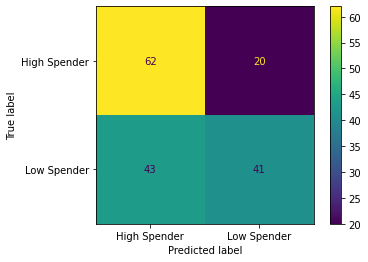

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(features_eval.LifetimeValueActual, features_eval.LifetimeValuePrediction, 
                      labels=rfc_classifier_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=rfc_classifier_model.classes_)
disp.plot()

#### Why might it matter to the business?
Hint- let's think of what actions the business might think to take based on our model's predictions.

.

.

.


### Which of our features were impactful in the model's predictions?

Let's look into a concept called "feature importance". Which pieces of information ended up being important in the model achieving the (albeit- mediocre) accuracy that it did?

Analyzing feature importance is valuable in making sure you can explain a model's predictions and why it "makes the decisions"
that it does. Most clients are understandably uncomfortable with a black box making recommendations for them, and they should be!

More than just explaining predictions, feature importance can act as an analysis of its own right. Knowing which pieces of information about your customers impact their likelihood to continue spending with you is a really valable output of a modeling exercise, without even deploying the model and making future predictions (yet!)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


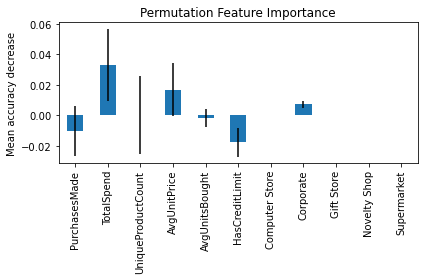

In [30]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(
    rfc_classifier_model, features_test, lv_test, n_repeats=10, random_state=42, n_jobs=2)

feature_names = features_test.columns

rfc_importances = pandas.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
rfc_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Permutation Feature Importance")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Next steps...
What are some ways you can think of that we could improve our model's performance? 

Think - what additional data could we get? What other features could we make?